In [46]:
import torch
from torch import Tensor
import torch.nn as nn
from torch_geometric.nn import DenseGCNConv

from icecream import ic

In [189]:
import numpy as np
from pathlib import Path
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

class TspDataset(Dataset):
    def __init__(self):
        super().__init__()
        data_root = Path("../data/processed_heuristic-threshold")
        instances = data_root / "instances" / "1"
        self.instances = sum((list(instance.iterdir()) for instance in instances.iterdir() if instance.stem != "1"), [])
    
    def get(self, idx):
        entry = self.instances[idx]
        with np.load(entry / "pairwise.npz") as data:
            distance_matrix = torch.tensor(data['arr_0'], dtype=torch.float)
        route_mask = torch.from_numpy(np.loadtxt(entry / "sol_mask.txt", dtype=np.float32))
        
        # route_distance = data['route_distance']

        graph = Data(x=torch.ones(distance_matrix.shape[0], 1, dtype=torch.float), edge_attr=distance_matrix, y=route_mask)
        return graph
    
    def len(self):
        return len(self.instances)    

In [190]:
from icecream import ic
from einops import rearrange

class ConvBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.activation_fn = nn.ReLU()

        self.conv1 = DenseGCNConv(input_dim, output_dim)
        self.edge_conv1 = nn.Conv2d(output_dim, 1, 1)
    
    def forward(self, graph):
        node_feats = self.conv1(graph.x, graph.edge_attr)
        node_feats = self.activation_fn(node_feats)
        edge_feats = rearrange(node_feats, "b n c -> b c n 1")
        edge_feats = self.edge_conv1(edge_feats @ edge_feats.mT)
        edge_feats = self.activation_fn(edge_feats)
        edge_feats = rearrange(edge_feats, "b 1 n1 n2 -> b n1 n2")

        return Data(x=node_feats, edge_attr=edge_feats)

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            ConvBlock(1, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 1),
            # ConvBlock(64),
            # ConvBlock(128),
        )

    def forward(self, graph):
        return self.model(graph)

In [191]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

tsp_dataset = TspDataset()
tsp_dataloader = DataLoader(tsp_dataset, batch_size=1, shuffle=False, pin_memory=True)
model = Model().to(device)
loss_fn = nn.BCELoss()

def dice_loss(y_pred, y_true):
    y_pred = torch.sigmoid(y_pred)
    # Flatten the predictions and ground truth
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Compute the intersection and union
    intersection = (y_true_flat * y_pred_flat).sum() + 1
    union = (y_true_flat).sum() + (y_pred_flat).sum() + 1

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union

    return dice_loss

loss_fn = dice_loss
# loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters())

from tqdm import tqdm

loss_arr = []
for epoch in range(5):
    for batch in tqdm(tsp_dataloader):
        graph = batch
        out = model(graph)
        out = out.edge_attr
        out = out.squeeze()
    
        # print(graph.y, out)
        loss = loss_fn(out, graph.y)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.detach().cpu().item()
        loss_arr.append(loss)

100%|█████████████████████████████████████████████████████████████████████████████| 1350/1350 [00:10<00:00, 134.30it/s]


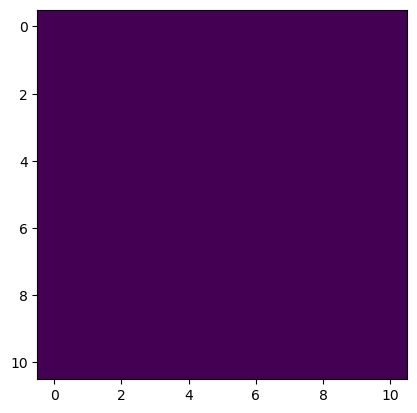

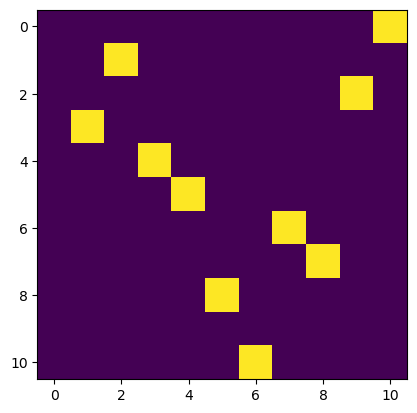

In [192]:
graph = tsp_dataset[10]

import matplotlib.pyplot as plt

with torch.no_grad():
    plt.imshow(model(graph).edge_attr.squeeze())
    plt.show()
    plt.imshow(graph.y)

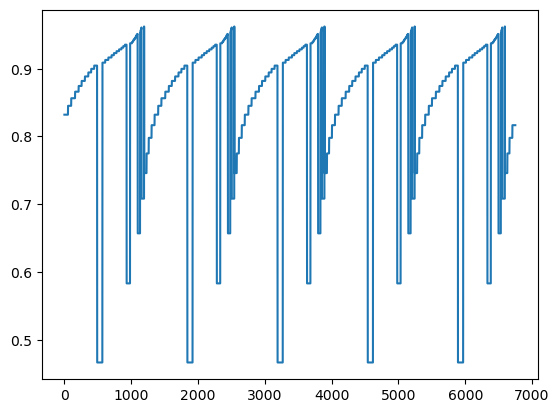

In [193]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)